In [1]:
import fish_models
import robofish.io

import numpy as np
from pathlib import Path

In [3]:
bins = 1
raycast_options = {
    "n_fish_bins": bins,
    "n_wall_raycasts": bins,
    "fov_angle_fish_bins": 2 * np.pi,
    "fov_angle_wall_raycasts": 2 * np.pi,
    "world_bounds": ([-50, -50], [50, 50]),
    # "far_plane": 142,
}

# Raycast in cm
raycast = fish_models.gym_interface.Raycast(**raycast_options)

# IO Files in cm, actions in m/s
data_folder = Path("data/live_female_female/train")
dset = fish_models.datasets.io_dataset.IoDataset(data_folder, raycast, output_strings=["poses","actions","views"],reduce_dim=2,max_files=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating views from 1 files.


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

Created IoDataset:
Reduced the first 3 dimensions from (1, 2, 8989) to (17978)
poses	(17978, 3):	consisting of x, y, calc_ori_rad.
actions	(17976, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(17976, 2):	1 fish_bins and 1 wall ray casts.



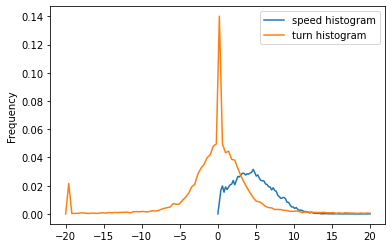

In [5]:
import importlib
importlib.reload(fish_models)

model = fish_models.models.andi.blind_stochastic_model.BlindStochasticModel(tau=0.01)
model.train(dset)
model.plot()

In [6]:
# not implemented yet
# fish_models.gym_interface.ModelStorage.save_model("model.pt", model, raycast.options)

generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, dset.world_size, dset.frequency
)

# initial_poses = dset.poses[0, :, 0]
timesteps = 1500
initial_poses = np.array([[0.0, 0.0, 0.0], [0.0, 3.0, 0.0]])
track = generator.create_track(2, timesteps, initial_poses=initial_poses)
f = generator.asIoFile(track)
f.save_as("__generated.hdf5")

100%|██████████| 1499/1499 [00:02<00:00, 664.07it/s]
<ipython-input-6-eaf964385e82>:12: DeprecatedWarning: asIoFile is deprecated as of 0.1 and will be removed in 0.3. The name of the function was changed to as_io_file.
  f = generator.asIoFile(track)


<HDF5 file "331910c8-2923-4b93-9d3f-0e1f9a998c9f" (mode r+)>

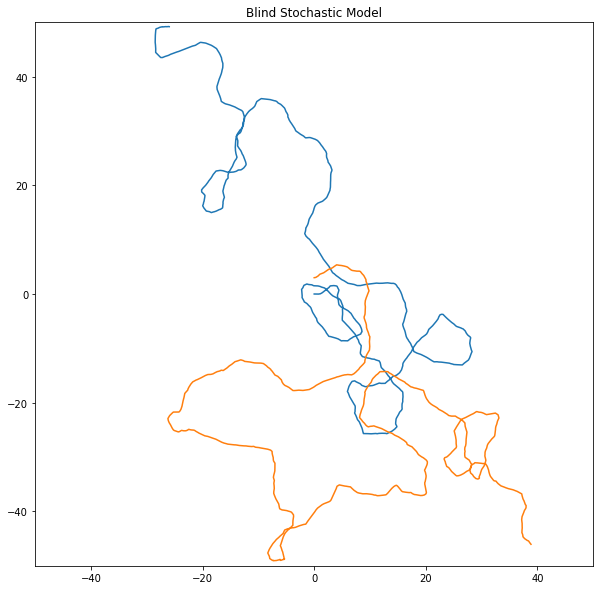

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title("Blind Stochastic Model")
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(2):
    plt.plot(
        track[fish_id, :, 0],
        track[fish_id, :, 1],
        label="reconstructed",
    )

plt.show()